In [2]:
import seaborn as sns
import pandas as pd
# import pandasql as ps
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
# import duckdb
import re
from sklearn.feature_extraction.text import CountVectorizer

from wa_analyzer.model import TextClustering
clustering = TextClustering()
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)
author_info_df.columns

Index(['author', 'Name', 'Gender', 'Entrance_nr', 'Unit_nr', 'Floor_nr',
       'Nr_rooms', 'Older_then_65'],
      dtype='object')

In [3]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
wa_df_all = pd.read_parquet(datafile)
# wa_df.head()
wa_df_all.columns
# wa_df.shape # rows = 4565, cols = 11

Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length'],
      dtype='object')

In [4]:

wa_df = wa_df_all[wa_df_all["message"].str.contains(r"lift|camera|trap|ventilatie", case=False, na=False)] ## ok

wa_df.shape # rows = 837, cols = 11
wa_df.describe()

,message_length,day_of_week,msg_length
count,294.000000,294.000000,294.000000
mean,241.051020,2.574830,241.051020
std,310.111024,1.865671,310.111024
min,11.000000,0.000000,11.000000
25%,84.250000,1.000000,84.250000
50%,147.000000,3.000000,147.000000
75%,280.500000,4.000000,280.500000
max,3117.000000,6.000000,3117.000000


In [5]:

def remove_url(text):
    return re.sub(r"https?://\S+", "", text)

# Always work on a copy to avoid the warning
wa_df = wa_df.copy()

# Clean the message column
wa_df.loc[:, "message"] = (
    wa_df["message"]
    .astype(str)                   # Ensure all are strings
    .str.replace("\n", " ", regex=False)  # Replace newlines with spaces
    .apply(remove_url)             # Remove URLs
    .str.lower()                   # Convert to lowercase
)

wa_df.describe()


,message_length,day_of_week,msg_length
count,294.000000,294.000000,294.000000
mean,241.051020,2.574830,241.051020
std,310.111024,1.865671,310.111024
min,11.000000,0.000000,11.000000
25%,84.250000,1.000000,84.250000
50%,147.000000,3.000000,147.000000
75%,280.500000,4.000000,280.500000
max,3117.000000,6.000000,3117.000000


In [6]:
# Now, we count every text and filter chuncks with size below 50.
wa_df["size"] = wa_df["message"].apply(lambda x: len(str(x)))
# wa_df.shape
wa_df["size"].describe()
# wa_df.columns
# wa_df = wa_df[wa_df["size"] > 50]
# wa_df.reset_index(inplace=True, drop=True)



count     294.000000
mean      237.870748
std       311.150212
min         0.000000
25%        82.250000
50%       144.000000
75%       275.500000
max      3117.000000
Name: size, dtype: float64

In [7]:
n = 140 # chunk default = 500, 270/4
min_parts = 2 # default = 2

authors = list(np.unique(wa_df.author))

# dict
corpus = {}

for author in authors:
    # concatenate all messages from author into one long string
    subset = wa_df[wa_df.author == author].reset_index()

    # Concatenate all their messages into one long string
    longseq = " ".join(subset.message)

    # chunk everything into n-sized parts
    # Split that long text into fixed-size “chunks”
    parts = [longseq[i : i + n] for i in range(0, len(longseq), n)]

    # clean urls , already done above!
    # parts = [remove_url(chunk) for chunk in parts]

    # remove double spaces, already done above!
    # parts = [re.sub(" +", " ", chunk) for chunk in parts]
    
    # keep only parts with more than min_parts
    if len(parts) > min_parts:
        corpus[author] = parts
corpus.keys()
# corpus.values()
# corpus.items()


dict_keys(['cackling-eland', 'captivating-dove', 'carefree-lark', 'cheerful-boar', 'cheerful-mule', 'entertaining-pig', 'ethereal-lapwing', 'eye-catching-hare', 'flexible-platypus', 'happy-beaver', 'intense-toad', 'joyful-okapi', 'limber-ostrich', 'radiant-coyote', 'resplendent-aardwolf', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-jellyfish', 'sunny-gazelle', 'upbeat-pigeon', 'vivid-rhinoceros', 'waggish-porcupine', 'zany-trout'])

In [8]:
import numpy as np

vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
X.shape

(7, 506)

In [9]:
from sklearn.metrics.pairwise import manhattan_distances

distance = manhattan_distances(X, X)
distance.shape, type(distance)

((7, 7), numpy.ndarray)

In [10]:
# Collect all chunks and labels from all authors
all_parts = []
labels = []

# Label_residents_metadata = "Older_then_65" # change later to list
Label_residents_metadata = "Gender" # change later to list
# Label_residents_metadata = "Entrance_nr" # change later to list
# Label_residents_metadata = "Nr_rooms" # change later to list
# Label_residents_metadata = "Floor_nr" # change later to list


for author, chunks in corpus.items():
    all_parts.extend(chunks)
    labels.extend([author] * len(chunks))

print(f"Total text chunks: {len(all_parts)}")

### NEW CODE ###
# Map author → Older_then_65 value
# age_map = dict(zip(author_info_df["author"], author_info_df["Older_then_65"]))
age_map = dict(zip(author_info_df["author"], author_info_df[Label_residents_metadata]))

# Create a list of age labels matching your text chunks
age_labels = [age_map[a] for a in labels]
# age_labels

Total text chunks: 503


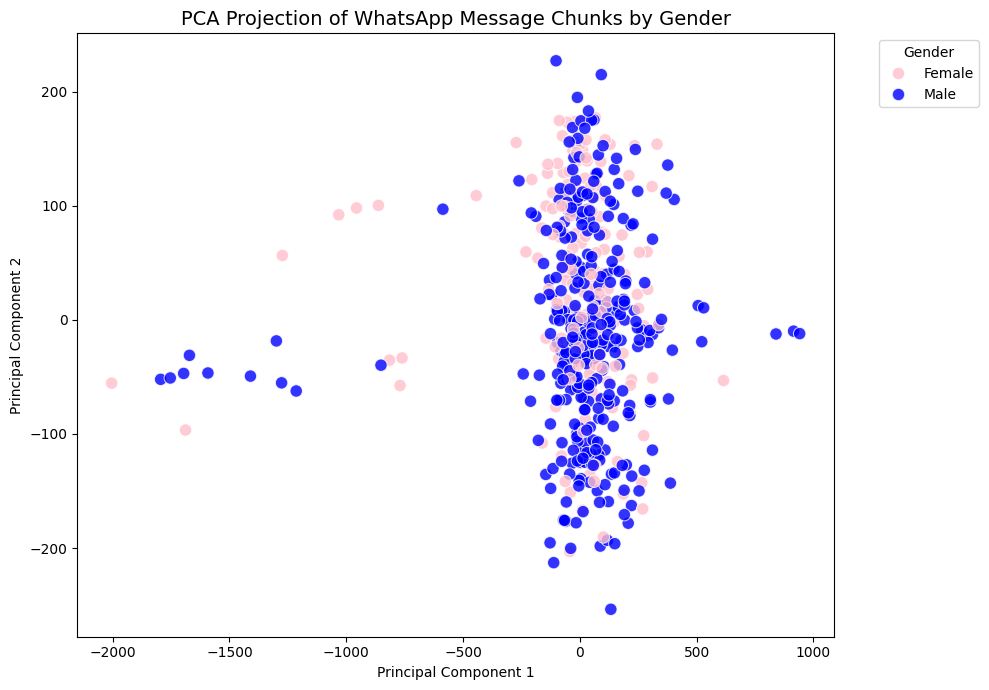

In [ ]:
##################
# PCA - PCA - PCA 
##################

# Vectorize all chunks
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(all_parts)

# Compute Manhattan distance matrix
from sklearn.metrics.pairwise import manhattan_distances
distance = manhattan_distances(X, X)

# PCA on the distance matrix
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
model = pca.fit_transform(distance)

# Build DataFrame for plotting
pca_df = pd.DataFrame(model, columns=["PC1", "PC2"])
# pca_df["author"] = labels
# pca_df["Older_then_65"] = age_labels
pca_df[Label_residents_metadata] = age_labels


# Plot with seaborn
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 7))

if Label_residents_metadata == "Older_then_65":
    palette = {True: "red", False: "blue"}  # 65+ in red, others in blue
elif Label_residents_metadata == "Gender":
    palette = {"Male": "blue", "Female": "pink"}  # example gender colors
elif Label_residents_metadata == "Entrance_nr":
    palette = {1: "green", 2: "orange"}  # entrance numbers colors
elif Label_residents_metadata == "Nr_rooms":
    palette = {3: "red", 5: "blue"}  # room numbers colors
elif Label_residents_metadata == "Floor_nr":
    palette = {
        1: "#1f77b4",  # muted blue
        2: "#ff7f0e",  # orange
        3: "#2ca02c",  # green
        4: "#d62728",  # red
        5: "#9467bd",  # purple
        6: "#8c564b",  # brown
        7: "#e377c2",  # pink
        8: "#7f7f7f",  # gray
    }
else:
    palette = "deep"  # default Seaborn palette


# Create scatter plot
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue=Label_residents_metadata,  # color by metadata label
    palette=palette,
    s=80,
    alpha=0.8
)

plt.title("PCA Projection of WhatsApp Message Chunks by geslacht: groep man/vrouw met eigen berichtstijl", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()